# Import and Verify State Shape Table (Table15) in MySQL

Name: Zihan  

This notebook creates and imports the **Australian State Shape Table (Table15)** into the MySQL database.  
It includes four main steps:
1. Export state geometries to a local CSV file  
2. Create the MySQL table schema (MULTIPOLYGON with SRID 7844)  
3. Insert geometries from CSV into MySQL  
4. Verify imported rows and preview sample data


## Step 1 — Load and Preview the State Boundary Shapefile
This step reads the ABS shapefile (`05_STE_2021_AUST_SHP_GDA2020.zip`) into a GeoDataFrame.  
The shapefile is compressed but can be read directly using the `zip://` protocol.


Shapefile successfully loaded.
Number of records: 10

--- Columns ---
['STE_CODE21', 'STE_NAME21', 'CHG_FLAG21', 'CHG_LBL21', 'AUS_CODE21', 'AUS_NAME21', 'AREASQKM21', 'LOCI_URI21', 'geometry']


,STE_CODE21,STE_NAME21,CHG_FLAG21,CHG_LBL21,AUS_CODE21,AUS_NAME21,AREASQKM21,LOCI_URI21,geometry
0,1,New South Wales,0,No change,AUS,Australia,8.007977e+05,http://linked.data.gov.au/dataset/asgsed3/STE/1,"MULTIPOLYGON (((159.0623 -31.50886, 159.06218 ..."
1,2,Victoria,0,No change,AUS,Australia,2.274962e+05,http://linked.data.gov.au/dataset/asgsed3/STE/2,"MULTIPOLYGON (((146.29286 -39.15778, 146.29341..."
2,3,Queensland,0,No change,AUS,Australia,1.730171e+06,http://linked.data.gov.au/dataset/asgsed3/STE/3,"MULTIPOLYGON (((142.5314 -10.68301, 142.53072 ..."
3,4,South Australia,0,No change,AUS,Australia,9.842314e+05,http://linked.data.gov.au/dataset/asgsed3/STE/4,"MULTIPOLYGON (((140.66025 -38.06256, 140.66006..."
4,5,Western Australia,0,No change,AUS,Australia,2.526632e+06,http://linked.data.gov.au/dataset/asgsed3/STE/5,"MULTIPOLYGON (((117.86953 -35.19108, 117.86961..."


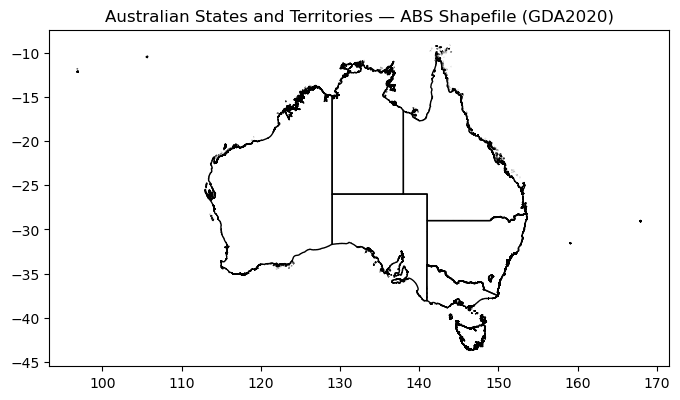

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Path to your shapefile (relative to project root)
shapefile_path = "01_raw_data/05_STE_2021_AUST_SHP_GDA2020.zip"

# Read shapefile directly from zip
gdf = gpd.read_file(f"zip://{shapefile_path}")

# Preview basic info
print("Shapefile successfully loaded.")
print(f"Number of records: {len(gdf)}")
print("\n--- Columns ---")
print(gdf.columns.tolist())

# Show the first few rows
display(gdf.head())

# Optional: Plot the shapes to visually confirm boundaries
gdf.plot(edgecolor="black", facecolor="none", figsize=(8, 8))
plt.title("Australian States and Territories — ABS Shapefile (GDA2020)")
plt.show()

## Step 2 - Export State Geometries to CSV
This step converts the shapefile into a simple CSV for backup and reusability.  
Each row includes the state name and the geometry in WKT format.

In [ ]:
## Step 2 - Export State Geometries to CSV
import geopandas as gpd
from pathlib import Path
from shapely.ops import transform
from shapely.geometry import mapping, shape

csv_output_path = Path("02_wrangled_data/Table15_StateShapeTable.csv")

state_df = gdf[["STE_NAME21", "geometry"]].rename(columns={"STE_NAME21": "state"})
state_df = state_df[state_df["geometry"].notna()]

# ① Reduce coordinate precision
def reduce_precision(geom, ndigits=3):
    if geom is None:
        return None
    geom_json = mapping(geom)
    def _round_coords(obj):
        if isinstance(obj, (list, tuple)):
            return [_round_coords(x) for x in obj]
        elif isinstance(obj, (float, int)):
            return round(obj, ndigits)
        return obj
    geom_json["coordinates"] = _round_coords(geom_json["coordinates"])
    return shape(geom_json)

print("Reducing coordinate precision to 3 decimal places...")
state_df["geometry"] = state_df["geometry"].apply(lambda g: reduce_precision(g, 3))

# ② Simplify geometry (reduce number of vertices)
def simplify_geometry(geom, tolerance=0.01):
    if geom is None:
        return None
    return geom.simplify(tolerance, preserve_topology=True)

print("Simplifying geometries to reduce number of points...")
state_df["geometry"] = state_df["geometry"].apply(simplify_geometry)

# ③ Swap coordinate order
def swap_xy(geom):
    if geom is None:
        return None
    return transform(lambda x, y, z=None: (y, x), geom)

print("Swapping (lat, lon) to (lon, lat) for WKT compatibility...")
state_df["geometry"] = state_df["geometry"].apply(swap_xy)

# ④ Export as WKT
state_df["geometry"] = state_df["geometry"].apply(lambda geom: geom.wkt if geom is not None else "")
state_df.to_csv(csv_output_path, index=False, encoding="utf-8-sig")

print(f"CSV file exported successfully to: {csv_output_path}")


Reducing coordinate precision to 3 decimal places...
Simplifying geometries to reduce number of points...
Swapping (lat, lon) to (lon, lat) for WKT compatibility...
CSV file exported successfully to: 02_wrangled_data\Table15_StateShapeTable.csv


C:\Users\zyyin1\AppData\Local\Temp\ipykernel_47960\4028460363.py:48: UserWarning: Geometry column does not contain geometry.
  state_df["geometry"] = state_df["geometry"].apply(lambda geom: geom.wkt if geom is not None else "")


## Step 3 - Create Table15 schema in MySQL
This step creates the **Table15_StateShapeTable** with a `MULTIPOLYGON` geometry column using SRID 7844 (GDA2020).


In [3]:
import mysql.connector
from mysql.connector import Error

# Database configuration
db_config = {
    'host': 'database-plantx.cqz06uycysiz.us-east-1.rds.amazonaws.com',
    'user': 'zihan',
    'password': '2002317Yzh12138.',
    'database': 'FIT5120_PlantX_Database',
    'allow_local_infile': True,
    'use_pure': True,
    'charset': 'utf8mb4'
}

try:
    connection = mysql.connector.connect(**db_config)
    if connection.is_connected():
        print("Successfully connected to MySQL server.")
        cursor = connection.cursor()

        cursor.execute("DROP TABLE IF EXISTS Table15_StateShapeTable;")

        # Create table WITH SRID
        create_table_15 = """
        CREATE TABLE Table15_StateShapeTable (
            state TEXT,
            geometry MULTIPOLYGON NOT NULL SRID 7844 -- Specify SRID 7844 here
        ) CHARACTER SET utf8mb4 COLLATE utf8mb4_unicode_ci;
        """
        cursor.execute(create_table_15)
        connection.commit()
        print("Table15_StateShapeTable schema created successfully with MULTIPOLYGON geometry and SRID 7844.")

except Error as e:
    print(f"Error during table creation: {e}")

finally:
    if 'connection' in locals() and connection.is_connected():
        cursor.close()
        connection.close()
        print("MySQL connection for creating Table15 schema closed.")

Successfully connected to MySQL server.
Table15_StateShapeTable schema created successfully with MULTIPOLYGON geometry and SRID 7844.
MySQL connection for creating Table15 schema closed.


## Step 4 - Insert State Geometry Data from CSV
This step loads geometries from the local CSV file and inserts them into the MySQL table using `ST_GeomFromText()` with SRID 7844.


In [4]:
import pandas as pd

# Load from CSV
state_csv = pd.read_csv(csv_output_path)
print(f"Loaded {len(state_csv)} records from CSV.")

try:
    connection = mysql.connector.connect(**db_config)
    if connection.is_connected():
        print("Connected to MySQL for inserting geometries.")
        cursor = connection.cursor()

        # Modified insert query to include SRID
        insert_query = """
        INSERT INTO Table15_StateShapeTable (state, geometry)
        VALUES (%s, ST_GeomFromText(%s, %s)); -- Add a placeholder for SRID
        """
        
        srid = 7844 # Define the SRID for GDA2020

        for _, row in state_csv.iterrows():
            # Pass the SRID as the third parameter in the tuple
            cursor.execute(insert_query, (row["state"], row["geometry"], srid))

        connection.commit()
        print(f"Successfully inserted {len(state_csv)} records into Table15_StateShapeTable.")

except Error as e:
    print(f"Error during inserting geometries: {e}")

finally:
    if 'connection' in locals() and connection.is_connected():
        cursor.close()
        connection.close()
        print("MySQL connection for inserting geometries closed.")

Loaded 9 records from CSV.
Connected to MySQL for inserting geometries.
Successfully inserted 9 records into Table15_StateShapeTable.
MySQL connection for inserting geometries closed.


## Step 5 - Verify Imported Rows and Preview (Table15)
This step confirms the number of imported geometries and shows a few sample records.

In [5]:
try:
    connection = mysql.connector.connect(**db_config)
    if connection.is_connected():
        cursor = connection.cursor()

        # Count rows
        cursor.execute("SELECT COUNT(*) FROM Table15_StateShapeTable;")
        row_count = cursor.fetchone()[0]
        print(f"Table15_StateShapeTable currently contains {row_count} rows.")

        # Preview 3 sample states
        print("\n--- Preview of sample states ---")
        cursor.execute("SELECT state, ST_GeometryType(geometry) FROM Table15_StateShapeTable LIMIT 3;")
        rows = cursor.fetchall()
        for state, geom_type in rows:
            print(f"{state} — {geom_type}")

except Error as e:
    print(f"Error during verification: {e}")

finally:
    if 'connection' in locals() and connection.is_connected():
        cursor.close()
        connection.close()
        print("MySQL connection for verification closed.")

Table15_StateShapeTable currently contains 8 rows.

--- Preview of sample states ---
New South Wales — MULTIPOLYGON
Victoria — MULTIPOLYGON
Queensland — MULTIPOLYGON
MySQL connection for verification closed.
